# 🤖 Entraînement RandomForest - Classificateur de Triage

**Dataset :** 79 cas équilibrés (20 ROUGE, 19 JAUNE, 20 VERT, 20 GRIS)

**Features :** 776 dimensions
- 768 : Embeddings CamemBERT-bio (symptômes)
- 6 : Constantes vitales (FC, FR, SpO2, TA, Temp)
- 2 : Patient (âge, sexe)

## 1️⃣ Imports

In [2]:
!pip install scikit-learn pandas matplotlib seaborn
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score
)



  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 8.0/8.0 MB 53.0 MB/s  0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
   ---------------------------------------- 0.0/36.3 MB ? eta -:--:--
   ------------------ --------------------- 16.8/36.3 MB 81.4 MB/s eta 0:00:01
   ---------------------------------------  36.2/36.3 MB 88.3 MB/s eta 0:00:01
   ---------------------------------------- 36.3/36.3 MB 76.5 MB/s  0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   -------- ------------------------------- 1/5 [scipy]
   -------- ------------------------------- 1/5 [scipy]
   -------- ------------------------------- 1/5 [scipy]
   -------- -----------

## 2️⃣ Charger le dataset

In [3]:
# Charger le dataset COMPLET (79 cas)
data_path = Path('../data/triage_dataset_complete.pkl')

with open(data_path, 'rb') as f:
    data = pickle.load(f)

X = data['X']
y = data['y']

print(f" Dataset chargé !")
print(f"   X shape : {X.shape}")
print(f"   y shape : {y.shape}")
print(f"   Features : {X.shape[1]} dimensions")
print(f"   Cas : {X.shape[0]}")

 Dataset chargé !
   X shape : (79, 776)
   y shape : (79,)
   Features : 776 dimensions
   Cas : 79


## 3️⃣ Distribution des classes

📊 DISTRIBUTION DES CLASSES
   ROUGE  : 20 ( 25.3%) ██████████
   JAUNE  : 19 ( 24.1%) █████████
   VERT   : 20 ( 25.3%) ██████████
   GRIS   : 20 ( 25.3%) ██████████


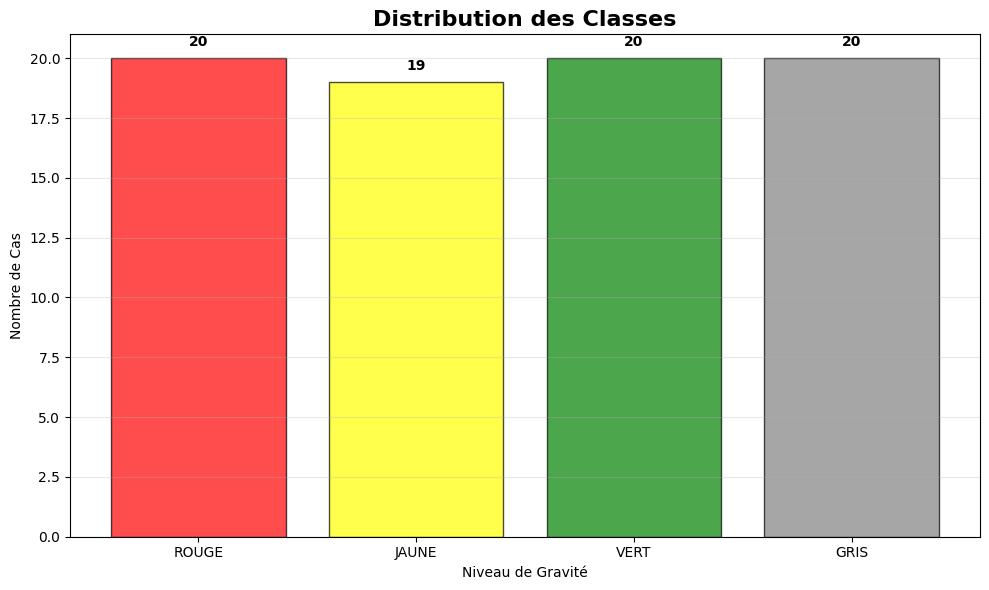

In [4]:
from collections import Counter

counts = Counter(y)

print("📊 DISTRIBUTION DES CLASSES")
print("="*60)
for label in ['ROUGE', 'JAUNE', 'VERT', 'GRIS']:
    count = counts[label]
    pct = (count / len(y)) * 100
    bar = '█' * (count // 2)
    print(f"   {label:6s} : {count:2d} ({pct:5.1f}%) {bar}")
print("="*60)

# Visualisation
plt.figure(figsize=(10, 6))
colors = {'ROUGE': 'red', 'JAUNE': 'yellow', 'VERT': 'green', 'GRIS': 'gray'}
bar_colors = [colors[label] for label in ['ROUGE', 'JAUNE', 'VERT', 'GRIS']]
values = [counts[label] for label in ['ROUGE', 'JAUNE', 'VERT', 'GRIS']]

plt.bar(['ROUGE', 'JAUNE', 'VERT', 'GRIS'], values, color=bar_colors, alpha=0.7, edgecolor='black')
plt.title('Distribution des Classes', fontsize=16, fontweight='bold')
plt.ylabel('Nombre de Cas')
plt.xlabel('Niveau de Gravité')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(values):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 4️⃣ Split Train/Test

In [5]:
# Split stratifié (maintient distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,  # 25% test
    random_state=42,
    stratify=y  # Important : maintient distribution
)

print(f"📊 SPLIT TRAIN/TEST")
print(f"="*60)
print(f"   Train : {len(X_train)} cas ({len(X_train)/len(X)*100:.0f}%)")
print(f"   Test  : {len(X_test)} cas ({len(X_test)/len(X)*100:.0f}%)")
print(f"="*60)

# Vérifier distribution train
print(f"\n   Distribution TRAIN :")
train_counts = Counter(y_train)
for label in ['ROUGE', 'JAUNE', 'VERT', 'GRIS']:
    print(f"      {label} : {train_counts[label]} cas")

print(f"\n   Distribution TEST :")
test_counts = Counter(y_test)
for label in ['ROUGE', 'JAUNE', 'VERT', 'GRIS']:
    print(f"      {label} : {test_counts[label]} cas")

📊 SPLIT TRAIN/TEST
   Train : 59 cas (75%)
   Test  : 20 cas (25%)

   Distribution TRAIN :
      ROUGE : 15 cas
      JAUNE : 14 cas
      VERT : 15 cas
      GRIS : 15 cas

   Distribution TEST :
      ROUGE : 5 cas
      JAUNE : 5 cas
      VERT : 5 cas
      GRIS : 5 cas


## 5️⃣ Entraîner RandomForest

In [6]:
print("🎓 Entraînement du modèle...\n")

# Créer et entraîner
clf = RandomForestClassifier(
    n_estimators=100,  # 100 arbres
    max_depth=10,      # Profondeur max
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1          # Utiliser tous les CPU
)

clf.fit(X_train, y_train)

print("✅ Modèle entraîné !")
print(f"   Nombre d'arbres : {clf.n_estimators}")
print(f"   Profondeur max : {clf.max_depth}")

🎓 Entraînement du modèle...

✅ Modèle entraîné !
   Nombre d'arbres : 100
   Profondeur max : 10


## 6️⃣ Prédictions

In [7]:
# Prédictions sur test
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"📊 PERFORMANCES SUR TEST SET")
print(f"="*60)
print(f"   Accuracy : {accuracy*100:.1f}%")
print(f"   F1-Score : {f1:.3f}")
print(f"="*60)

📊 PERFORMANCES SUR TEST SET
   Accuracy : 50.0%
   F1-Score : 0.497


## 7️⃣ Rapport de classification

In [8]:
print("\n📋 RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("="*60)
print(classification_report(
    y_test, 
    y_pred,
    target_names=['GRIS', 'JAUNE', 'ROUGE', 'VERT'],
    zero_division=0
))


📋 RAPPORT DE CLASSIFICATION DÉTAILLÉ
              precision    recall  f1-score   support

        GRIS       0.50      0.60      0.55         5
       JAUNE       0.50      0.40      0.44         5
       ROUGE       0.80      0.80      0.80         5
        VERT       0.20      0.20      0.20         5

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.50        20
weighted avg       0.50      0.50      0.50        20



## 8️⃣ Matrice de confusion


🔢 MATRICE DE CONFUSION
       ROUGE  JAUNE  VERT  GRIS
ROUGE      4      1     0     0
JAUNE      0      2     2     1
VERT       1      1     1     2
GRIS       0      0     2     3

(Lignes = Vrai, Colonnes = Prédit)


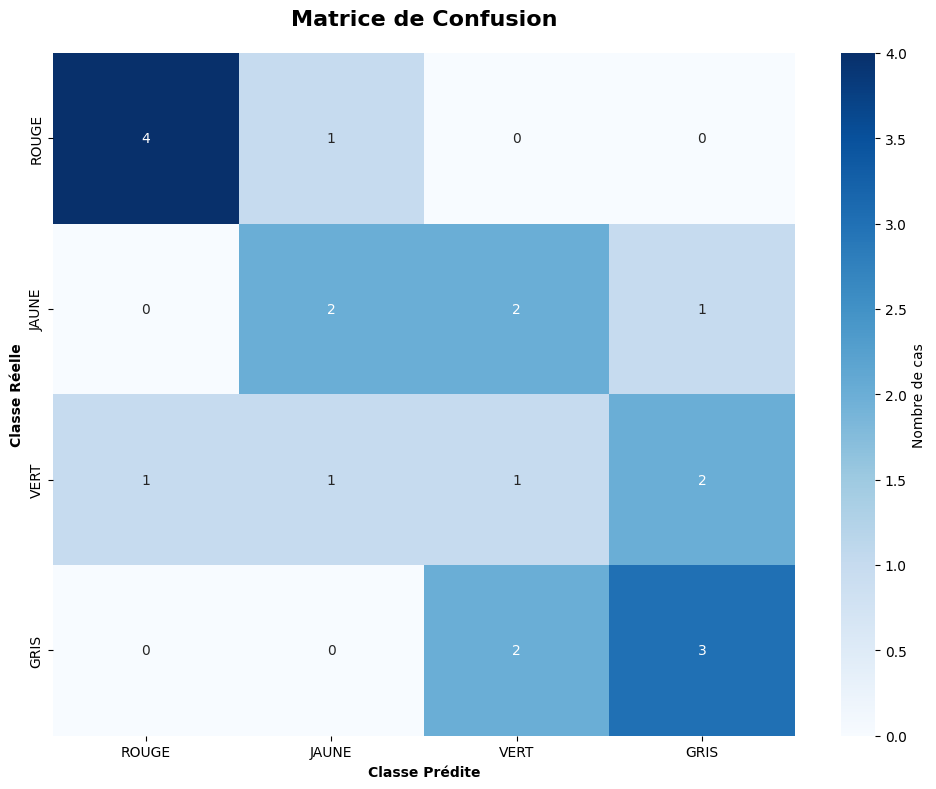

In [9]:
# Calculer matrice
cm = confusion_matrix(y_test, y_pred, labels=['ROUGE', 'JAUNE', 'VERT', 'GRIS'])

# Afficher texte
print("\n🔢 MATRICE DE CONFUSION")
print("="*60)
cm_df = pd.DataFrame(
    cm,
    index=['ROUGE', 'JAUNE', 'VERT', 'GRIS'],
    columns=['ROUGE', 'JAUNE', 'VERT', 'GRIS']
)
print(cm_df)
print("\n(Lignes = Vrai, Colonnes = Prédit)")

# Visualiser
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['ROUGE', 'JAUNE', 'VERT', 'GRIS'],
    yticklabels=['ROUGE', 'JAUNE', 'VERT', 'GRIS'],
    cbar_kws={'label': 'Nombre de cas'}
)
plt.title('Matrice de Confusion', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Classe Réelle', fontweight='bold')
plt.xlabel('Classe Prédite', fontweight='bold')
plt.tight_layout()
plt.show()

## 9️⃣ Validation croisée

In [10]:
# Cross-validation 5-fold
print("🔄 VALIDATION CROISÉE (5-fold)")
print("="*60)

cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

print(f"   Scores par fold :")
for i, score in enumerate(cv_scores, 1):
    print(f"      Fold {i} : {score*100:.1f}%")

print(f"\n   Moyenne : {cv_scores.mean()*100:.1f}% (± {cv_scores.std()*100:.1f}%)")
print("="*60)

🔄 VALIDATION CROISÉE (5-fold)
   Scores par fold :
      Fold 1 : 50.0%
      Fold 2 : 62.5%
      Fold 3 : 56.2%
      Fold 4 : 37.5%
      Fold 5 : 66.7%

   Moyenne : 54.6% (± 10.2%)


## 🔟 Importance des features

In [11]:
# Top 20 features les plus importantes
feature_importance = clf.feature_importances_

# Indices des constantes vitales
vitals_indices = {
    768: 'FC (fréquence cardiaque)',
    769: 'FR (fréquence respiratoire)',
    770: 'SpO2 (saturation)',
    771: 'TA systolique',
    772: 'TA diastolique',
    773: 'Température',
    774: 'Âge',
    775: 'Sexe'
}

print("\n🔝 TOP 10 FEATURES LES PLUS IMPORTANTES")
print("="*60)

# Trier par importance
indices = np.argsort(feature_importance)[::-1][:10]

for rank, idx in enumerate(indices, 1):
    importance = feature_importance[idx]
    if idx in vitals_indices:
        name = vitals_indices[idx]
    else:
        name = f"Embedding symptôme #{idx}"
    print(f"   {rank:2d}. {name:30s} : {importance:.4f}")

print("="*60)


🔝 TOP 10 FEATURES LES PLUS IMPORTANTES
    1. FC (fréquence cardiaque)       : 0.0378
    2. FR (fréquence respiratoire)    : 0.0164
    3. SpO2 (saturation)              : 0.0141
    4. Âge                            : 0.0116
    5. Embedding symptôme #95         : 0.0109
    6. Embedding symptôme #425        : 0.0084
    7. Température                    : 0.0079
    8. TA diastolique                 : 0.0077
    9. Embedding symptôme #511        : 0.0075
   10. Embedding symptôme #385        : 0.0072


## 1️⃣1️⃣ Test sur cas spécifiques

In [12]:
print("\n🧪 TEST SUR CAS SPÉCIFIQUES")
print("="*60)

# Prendre 5 cas aléatoires du test set
np.random.seed(42)
test_indices = np.random.choice(len(X_test), size=min(5, len(X_test)), replace=False)

for i, idx in enumerate(test_indices, 1):
    x_case = X_test[idx:idx+1]
    y_true = y_test[idx]
    y_pred_case = clf.predict(x_case)[0]
    proba = clf.predict_proba(x_case)[0]
    
    # Probabilités par classe
    proba_dict = dict(zip(clf.classes_, proba))
    
    print(f"\n   Cas #{i}")
    print(f"      Vrai label : {y_true}")
    print(f"      Prédiction : {y_pred_case} {'✅' if y_pred_case == y_true else '❌'}")
    print(f"      Confiance :")
    for label in ['ROUGE', 'JAUNE', 'VERT', 'GRIS']:
        prob = proba_dict.get(label, 0)
        bar = '█' * int(prob * 20)
        print(f"         {label:6s} : {prob*100:5.1f}% {bar}")

print("\n" + "="*60)


🧪 TEST SUR CAS SPÉCIFIQUES

   Cas #1
      Vrai label : ROUGE
      Prédiction : ROUGE ✅
      Confiance :
         ROUGE  :  43.0% ████████
         JAUNE  :  23.0% ████
         VERT   :   4.0% 
         GRIS   :  30.0% ██████

   Cas #2
      Vrai label : GRIS
      Prédiction : VERT ❌
      Confiance :
         ROUGE  :  14.0% ██
         JAUNE  :  27.0% █████
         VERT   :  35.0% ███████
         GRIS   :  24.0% ████

   Cas #3
      Vrai label : JAUNE
      Prédiction : GRIS ❌
      Confiance :
         ROUGE  :  21.0% ████
         JAUNE  :  30.0% ██████
         VERT   :  19.0% ███
         GRIS   :  30.0% ██████

   Cas #4
      Vrai label : VERT
      Prédiction : VERT ✅
      Confiance :
         ROUGE  :  18.0% ███
         JAUNE  :  25.0% █████
         VERT   :  31.0% ██████
         GRIS   :  26.0% █████

   Cas #5
      Vrai label : VERT
      Prédiction : GRIS ❌
      Confiance :
         ROUGE  :  21.0% ████
         JAUNE  :  27.0% █████
         VERT   :  16.0

## 1️⃣2️⃣ Sauvegarder le modèle

In [ ]:
# Créer dossier models
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Sauvegarder
model_path = models_dir / 'random_forest_triage.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(clf, f)

print(f"✅ Modèle sauvegardé : {model_path}")
print(f"\n📦 Taille du fichier : {model_path.stat().st_size / 1024:.1f} KB")